In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

seed = 0



In [2]:
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [3]:
#feat_names = list(df.columns)
feat_names = [col for col in df.columns if col != 'category']
print(feat_names)

['num__budget', 'num__revenue', 'num__popularity', 'num__runtime', 'num__vote_count', 'num__release_year', 'num__release_month', 'cat__original_language_ar', 'cat__original_language_bn', 'cat__original_language_bs', 'cat__original_language_cn', 'cat__original_language_cs', 'cat__original_language_da', 'cat__original_language_de', 'cat__original_language_el', 'cat__original_language_en', 'cat__original_language_es', 'cat__original_language_et', 'cat__original_language_fa', 'cat__original_language_fi', 'cat__original_language_fr', 'cat__original_language_he', 'cat__original_language_hi', 'cat__original_language_hu', 'cat__original_language_id', 'cat__original_language_it', 'cat__original_language_ja', 'cat__original_language_ko', 'cat__original_language_la', 'cat__original_language_mk', 'cat__original_language_nb', 'cat__original_language_nl', 'cat__original_language_no', 'cat__original_language_pl', 'cat__original_language_pt', 'cat__original_language_ro', 'cat__original_language_ru', '

In [4]:
#print(df.info())
#print(df.head())

In [5]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])  # Replace with your target column


X = df.drop('category', axis=1)
Y = df['category']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## CART Algorithm Decision Tree

In [6]:
cart_tree = DecisionTreeClassifier(random_state=seed)

In [7]:
cart_tree.fit(X_train, Y_train_encoded)

DecisionTreeClassifier(random_state=0)

In [8]:
Y_pred = cart_tree.predict(X_test)

In [9]:

accuracy = accuracy_score(Y_test_encoded, Y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6392


In [10]:
print(classification_report(Y_test_encoded, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       450
           1       0.51      0.53      0.52       430
           2       0.65      0.66      0.65       429
           3       0.58      0.57      0.57       448

    accuracy                           0.64      1757
   macro avg       0.64      0.64      0.64      1757
weighted avg       0.64      0.64      0.64      1757



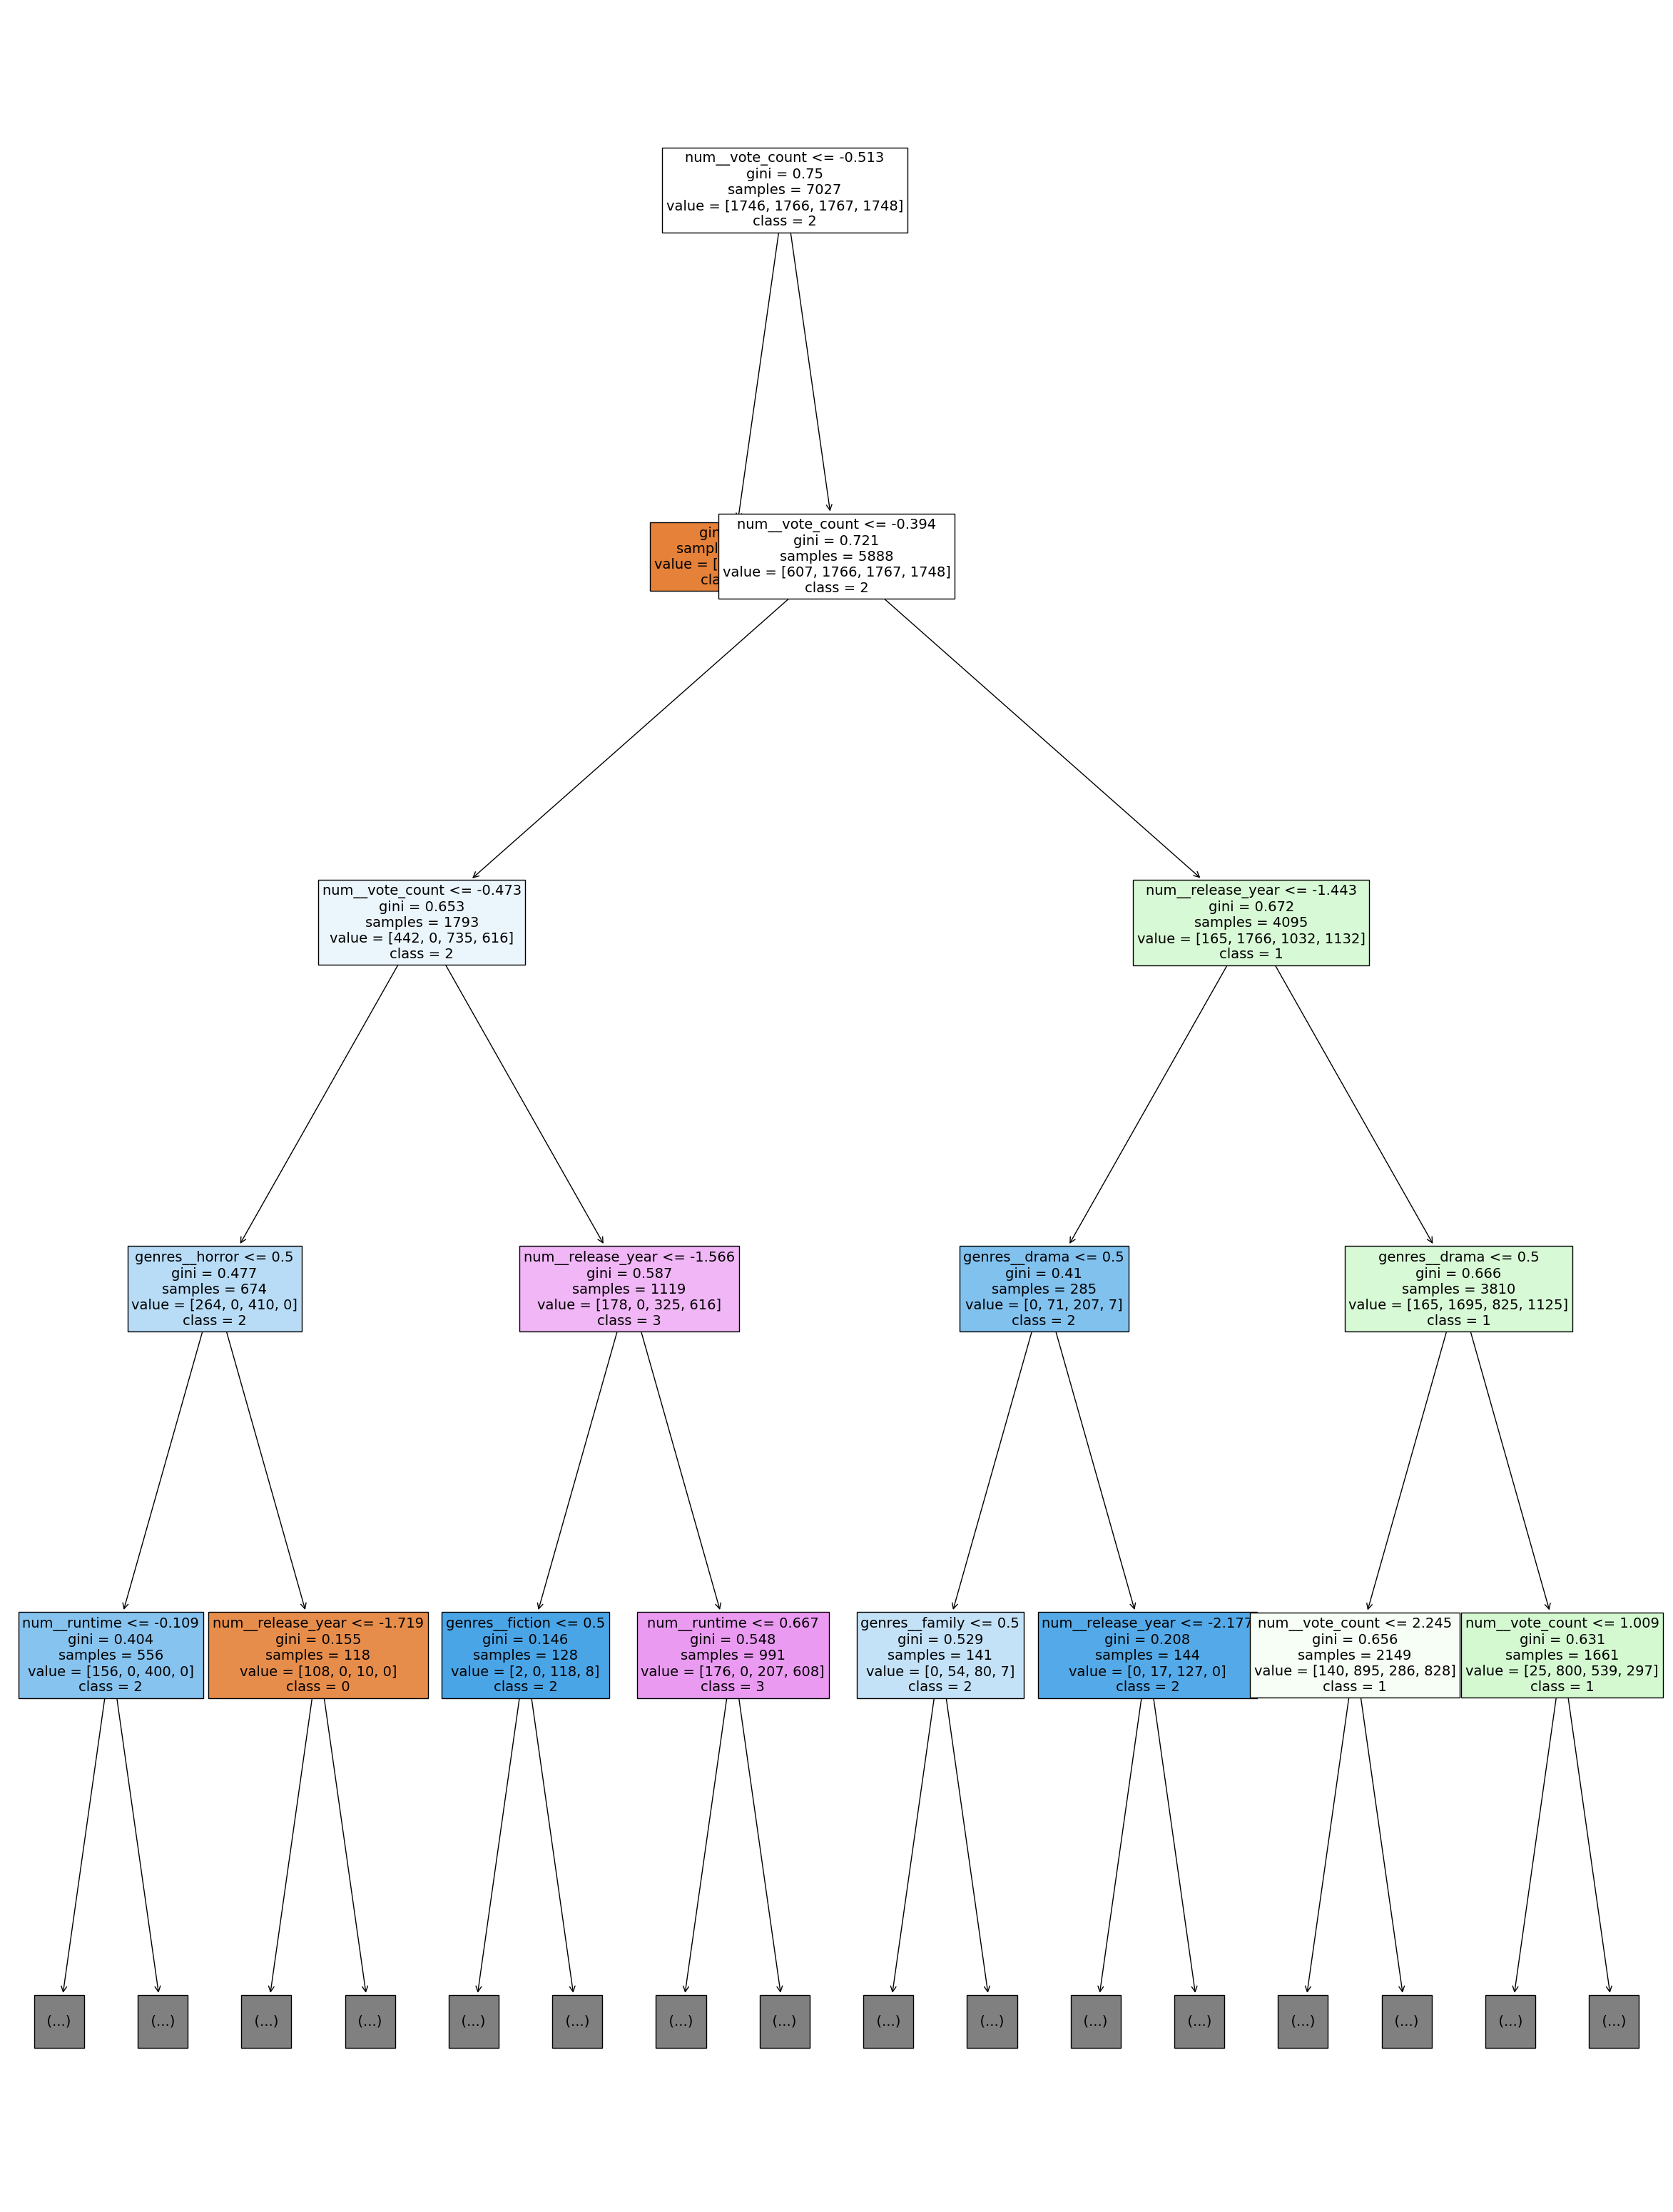

In [11]:

class_names = [str(class_) for class_ in label_encoder.classes_]
# Visualizing the decision tree with bigger rectangles and text
plt.figure(figsize=(30, 40)) 
plot_tree(cart_tree, 
          filled=True, 
          feature_names=feat_names, 
          class_names=class_names, 
          max_depth=4, 
          fontsize=14)  
plt.show()



In [12]:
# Writing the decision tree rules as text
tree_rules = export_text(cart_tree, feature_names=feat_names)
print(tree_rules)



|--- num__vote_count <= -0.51
|   |--- class: 0
|--- num__vote_count >  -0.51
|   |--- num__vote_count <= -0.39
|   |   |--- num__vote_count <= -0.47
|   |   |   |--- genres__horror <= 0.50
|   |   |   |   |--- num__runtime <= -0.11
|   |   |   |   |   |--- num__release_year <= -0.77
|   |   |   |   |   |   |--- num__popularity <= -0.22
|   |   |   |   |   |   |   |--- production_companies__orionpictures <= 0.50
|   |   |   |   |   |   |   |   |--- overview__finds <= 0.41
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- overview__finds >  0.41
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- production_companies__orionpictures >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- num__popularity >  -0.22
|   |   |   |   |   |   |   |--- num__vote_count <= -0.49
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- num__vote_count >  -0.49
|   |   |   |   |   |  

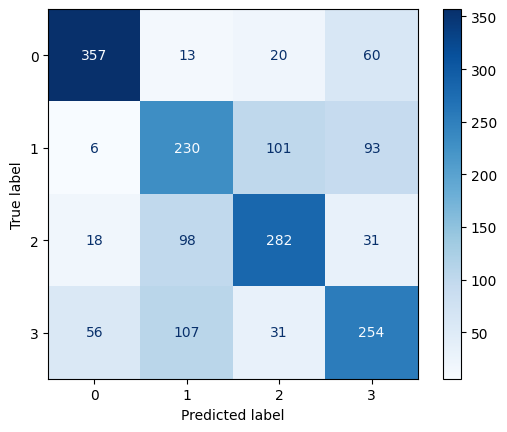

In [13]:
# Confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


#### Wrappers to  tune parameters

#### RandomizedSearchCV

In [14]:
"""
from sklearn.model_selection import RandomizedSearchCV

new_cart_tree = DecisionTreeClassifier(random_state=seed)


param_grid = {
    'criterion': ['gini', 'entropy'],  # Split quality
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
}

random_search = RandomizedSearchCV(estimator=new_cart_tree, 
                                   param_distributions=param_grid, 
                                   n_iter=500, 
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=seed,
                                   n_jobs=-1)


random_search.fit(X_train, Y_train_encoded)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

#Output: 
#Fitting 5 folds for each of 432 candidates, totalling 2160 fits, 720 fits failed out of a total of 2160.
#Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'entropy'}
#Best Cross-Validation Score: 0.543764041246716
"""


'\nfrom sklearn.model_selection import RandomizedSearchCV\n\nnew_cart_tree = DecisionTreeClassifier(random_state=seed)\n\n\nparam_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],  # Split quality\n    \'max_depth\': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10],  # Minimum samples required to split an internal node\n    \'min_samples_leaf\': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\'],  # Number of features to consider for the best split\n}\n\nrandom_search = RandomizedSearchCV(estimator=new_cart_tree, \n                                   param_distributions=param_grid, \n                                   n_iter=500, \n                                   scoring=\'accuracy\',\n                                   cv=5, \n                                   verbose=1, \n                                   random_state=seed,\n                                   n_job

In [15]:
# Best parameters from RandomizedSearchCV wrapper output
best_params = {
    'criterion': 'entropy',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2
}

new_cart_tree = DecisionTreeClassifier(random_state=seed, **best_params)

new_cart_tree.fit(X_train, Y_train_encoded)

Y_pred_new = new_cart_tree.predict(X_test)

In [16]:

accuracy = accuracy_score(Y_test_encoded, Y_pred_new)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5287


In [17]:
print(classification_report(Y_test_encoded, Y_pred_new))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       450
           1       0.41      0.43      0.42       430
           2       0.53      0.53      0.53       429
           3       0.46      0.46      0.46       448

    accuracy                           0.53      1757
   macro avg       0.53      0.53      0.53      1757
weighted avg       0.53      0.53      0.53      1757



#### GridSearch

In [18]:

param_grid_search = {
    'max_depth': [5, 10, 15, 20, 25, 30, 40, 50, 60, 100, None],    
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8, 1],      
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10, 15, 20],            
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 10],                    
    'criterion': ['gini', 'entropy'],                               
    'splitter': ['best', 'random']                                  
}



In [19]:
grid_search = GridSearchCV(
    estimator=cart_tree, 
    param_grid=param_grid_search, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [20]:
#grid_search.fit(X_train, Y_train_encoded)

#print("Best parameters:", grid_search.best_params_)

#Output:
#~36min
#Fitting 5 folds for each of 19404 candidates, totalling 97020 fits, 13860 fits failed out of a total of 97020.
#Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}


In [21]:
best_params = {
    'criterion': 'entropy', 
    'max_depth': 10, 
    'max_features': 0.8, 
    'min_samples_leaf': 5, 
    'min_samples_split': 15, 
    'splitter': 'best'
}

best_cart_model = DecisionTreeClassifier(**best_params, random_state=seed)


best_cart_model.fit(X_train, Y_train_encoded)
Y_pred_best = best_cart_model.predict(X_test)

In [22]:
accuracy = accuracy_score(Y_test_encoded, Y_pred_best)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6716


In [23]:
print(classification_report(Y_test_encoded, Y_pred_best))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       450
           1       0.53      0.60      0.56       430
           2       0.73      0.60      0.66       429
           3       0.58      0.70      0.63       448

    accuracy                           0.67      1757
   macro avg       0.69      0.67      0.68      1757
weighted avg       0.70      0.67      0.68      1757



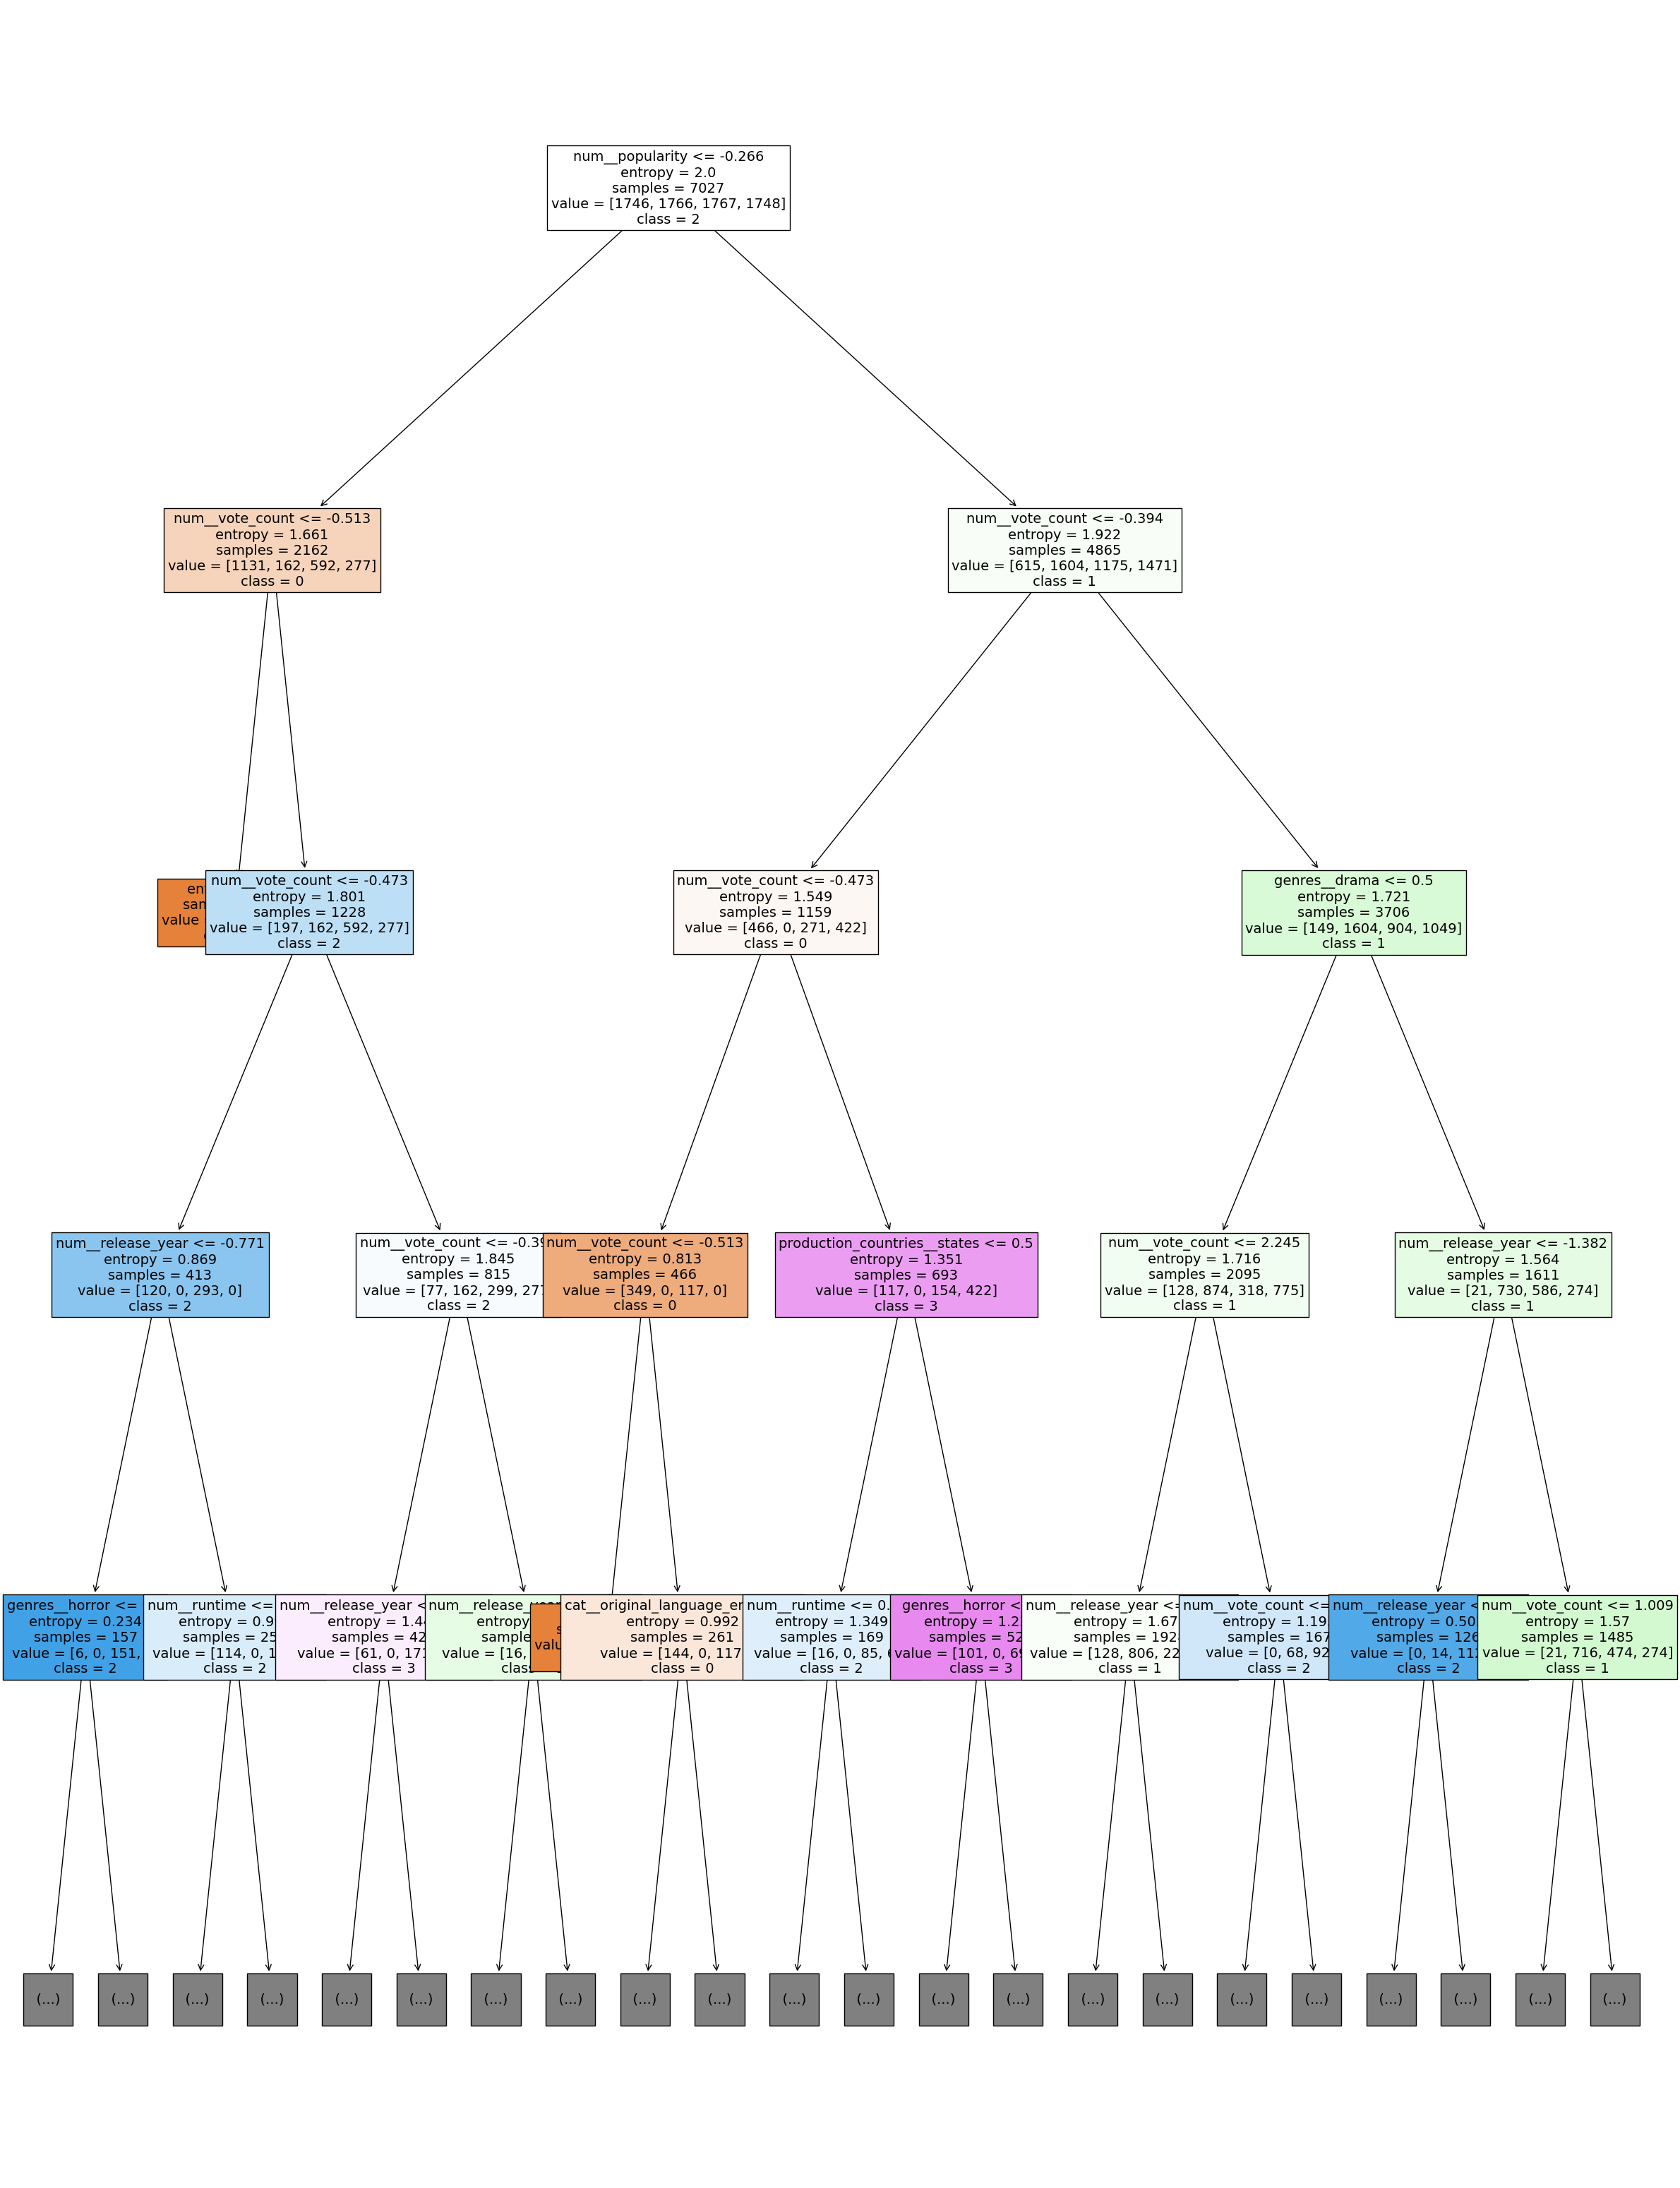

In [24]:
class_names = [str(class_) for class_ in label_encoder.classes_]
plt.figure(figsize=(30, 40)) 
plot_tree(best_cart_model, 
          filled=True, 
          feature_names=feat_names, 
          class_names=class_names, 
          max_depth=4, 
          fontsize=14)  
plt.show()


In [25]:
tree_rules = export_text(best_cart_model, feature_names=feat_names)
print(tree_rules)

|--- num__popularity <= -0.27
|   |--- num__vote_count <= -0.51
|   |   |--- class: 0
|   |--- num__vote_count >  -0.51
|   |   |--- num__vote_count <= -0.47
|   |   |   |--- num__release_year <= -0.77
|   |   |   |   |--- genres__horror <= 0.50
|   |   |   |   |   |--- genres__fantasy <= 0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- genres__fantasy >  0.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- genres__horror >  0.50
|   |   |   |   |   |--- class: 2
|   |   |   |--- num__release_year >  -0.77
|   |   |   |   |--- num__runtime <= -0.11
|   |   |   |   |   |--- genres__documentary <= 0.50
|   |   |   |   |   |   |--- num__runtime <= -1.66
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- num__runtime >  -1.66
|   |   |   |   |   |   |   |--- production_countries__america <= 0.50
|   |   |   |   |   |   |   |   |--- num__release_year <= -0.22
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |

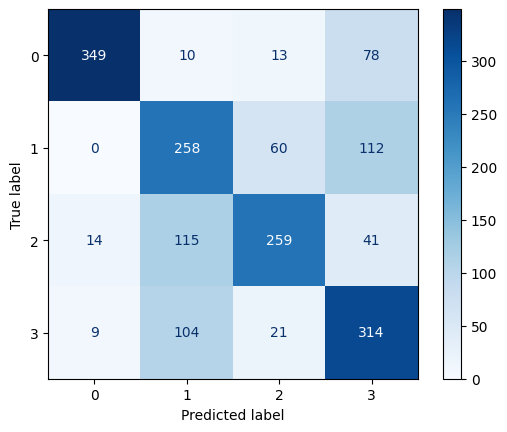

In [26]:
# Confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
